<a href="https://colab.research.google.com/github/troncosofranco/IoT-Spark/blob/main/Sentiment_Analysis_w_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem statement

Social validation and positive recommendation represent crucial parameters to purchase customer decisions. In this scenario, the data analysis of comments and opinions of customers is a valuable tool to understand their demands and provide to them with a better quality service based on real feedback.

Comments represent a large amount of unstructured data. Natural Language Processing (NLP) is concerned with creating computational models that process and understand natural language. Using this approach, it is possible to perform sentiment analysis to identify public sentiment toward certain words or topics.

In this notebook, Twitter sentiment analysis using Spark is performed.

#Twitter Sentiment Analysis

##Dataset attributes
It contains 1600000 tweets extracted using the twitter api. The tweets have been annotated (negative:0, positive:4). Source: [Twitter Sentiment Analysis Dataset Kaggle](https://www.kaggle.com/code/diniftikhar025/sentimentanalysiswithlogisticregressioninpyspark/data).

The dataset contains the following features:

- **target:** the polarity of the tweet (negative:2, neutral:2, positive:4).
- **ids:** The id of the tweet (2087).
- **date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009).
- **flag:** The query (lyx). If there is no query, then this value is NO_QUERY.
- **user:** the user that tweeted.
- **text:** the text of the tweet.

#1. Import modules

In [1]:
!pip install pyspark
!pip install kaggle

#Visual representation of words
!pip install wordcloud 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Spark capabilities
import pyspark
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

from warnings import filterwarnings
filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 15 kB/s 
     |████████████████████████████████| 199 kB 31.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=6305819837c23f0caf3ea9dac00a623355e2a262ad75914c340872ac65b52a28
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#Import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

#Spark session configuration 
spark = SparkSession.builder.master("local").appName("Twitter_Sentiment_Analysis").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=Twitter_Sentiment_Analysis>

#2. Load the data

In [4]:
#Load dataset
df = spark.read.csv('twitter_dataset.csv',inferSchema=True)

In [5]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [6]:
#Rename columns
df= df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
.withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')

df.show(5)

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [7]:
#Column datatypes
#df.printSchema()
df.dtypes


[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

In [8]:
#dataframe info
print('Instances: ', df.count())
print('Columns: ', len(df.columns))

Instances:  1600000
Columns:  6


In [9]:
#Check for missing or null values
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

#df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

+------+---+----+----+----+----+
|target| id|date|flag|user|text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



In [10]:
#Check for duplicates
df = df.dropDuplicates()
print('Instances after duplicates remotion: ', df.count())

Instances after duplicates remotion:  1600000


There are no duplicates, missing, or null values in the dataset. Only `text` and `target` variables are significant for this work. This, the rest of varaibles are removed.

In [11]:
#Drop features
drop_val = ('id','date','flag','user')
df = df.drop(*drop_val)
df.show(5)

+------+--------------------+
|target|                text|
+------+--------------------+
|     0|            At work |
|     0|@astewart87 oh my...|
|     0|i need new glasse...|
|     0|Getting changed i...|
|     0|really now, time ...|
+------+--------------------+
only showing top 5 rows



In [12]:
#Dataframe summary
#df.summary().show
#df.info().show

In [13]:
df.select('target').distinct().show()

+------+
|target|
+------+
|     4|
|     0|
+------+



There are only two values according to dataset description, negative:0 and positive:4. Positive:1 is adopted.

In [14]:
#Temporal view
df.createOrReplaceTempView('temp')

#Value remplacement and 'target' -> 'label'
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')


In [15]:
#df.show(5)
#df.tail(5)
df.groupby('label').count().show()


+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



#3. Data cleaning and processing

Remove stopwords, punctuations, links, and others.

The Preprocessing steps in NLP involve the following intem: 

1. **Lower Casing**
2. **Replacing URLs:** Links starting with "http" or "https" or "www" are replaced by "URL".
3. **Replacing Emojis**
4. **Replacing Usernames:** Replace @Usernames with word "USER". 
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

The processing steps were carried out following [Nikit Periwal](https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners#Preprocess-Text) procedure

In [16]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [17]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 10.8 ms, sys: 1.31 ms, total: 12.1 ms
Wall time: 78.5 ms


In [20]:
df.show(10)

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|            At work |                work|
|  0.0|@astewart87 oh my...|oh gosh made emot...|
|  0.0|i need new glasse...|need new glasses ...|
|  0.0|Getting changed i...|getting changed h...|
|  0.0|really now, time ...|really time sleep...|
|  0.0|pfff i want to go...|pfff want go back...|
|  0.0|Currently watchin...|currently watchin...|
|  0.0|What a bad day! N...|bad day need comf...|
|  0.0|Tried to install ...|tried install twi...|
|  0.0|Having casual, un...|casual unprotecte...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [21]:
df = df.drop("text")

In [22]:
df.show(5)

+-----+--------------------+
|label|        text_cleaned|
+-----+--------------------+
|  0.0|                work|
|  0.0|oh gosh made emot...|
|  0.0|need new glasses ...|
|  0.0|getting changed h...|
|  0.0|really time sleep...|
+-----+--------------------+
only showing top 5 rows



#4. Data analysis and visualization

Once data have been cleaned, it is possible to performs data analysis.

##4.1. Most Common Words in the Tweets

In [23]:
#Python counter
from collections import Counter
from tqdm import tqdm
pandas_df = df.toPandas()

positive_words = Counter()
negative_words = Counter()

counts = {1:positive_words,0:negative_words}

# iterate over every data row
for i in tqdm(range(len(pandas_df))):
    sentiment_class = pandas_df.iloc[i]['label']
    for word in pandas_df.iloc[i]['text_cleaned'].split():
        if word in counts[sentiment_class]:
            counts[sentiment_class][word] += 1
        else:
            counts[sentiment_class][word] = 1
            
top_words_positive_count = sorted(positive_words.items(), key = lambda x: x[1],reverse=True)[:20]
top_words_negative_count = sorted(negative_words.items(), key = lambda x: x[1],reverse=True)[:20]

100%|██████████| 1600000/1600000 [04:41<00:00, 5690.50it/s]


In [24]:
# Creating subplots for the most common words in each class
from plotly.subplots import make_subplots
import plotly.graph_objs as go
fig = make_subplots(rows=2, cols=1,subplot_titles=("Positive Tweets","Negative Tweets"))              

#Positive Tweets
x,y = zip(*top_words_positive_count)
fig.append_trace(go.Bar(x = x,y = y,name = 'Positive'),row=1, col=1)

#Negative Tweets
x,y = zip(*top_words_negative_count)
fig.append_trace(go.Bar(x = x, y = y, name = 'Negative'), row=2, col=1)
fig.update_layout(height=500, width=900, title_text="Top words in different classes",showlegend=False)
fig.show()

## 4.2. Wordcloud

Most common words of positive tweets using wordcloud

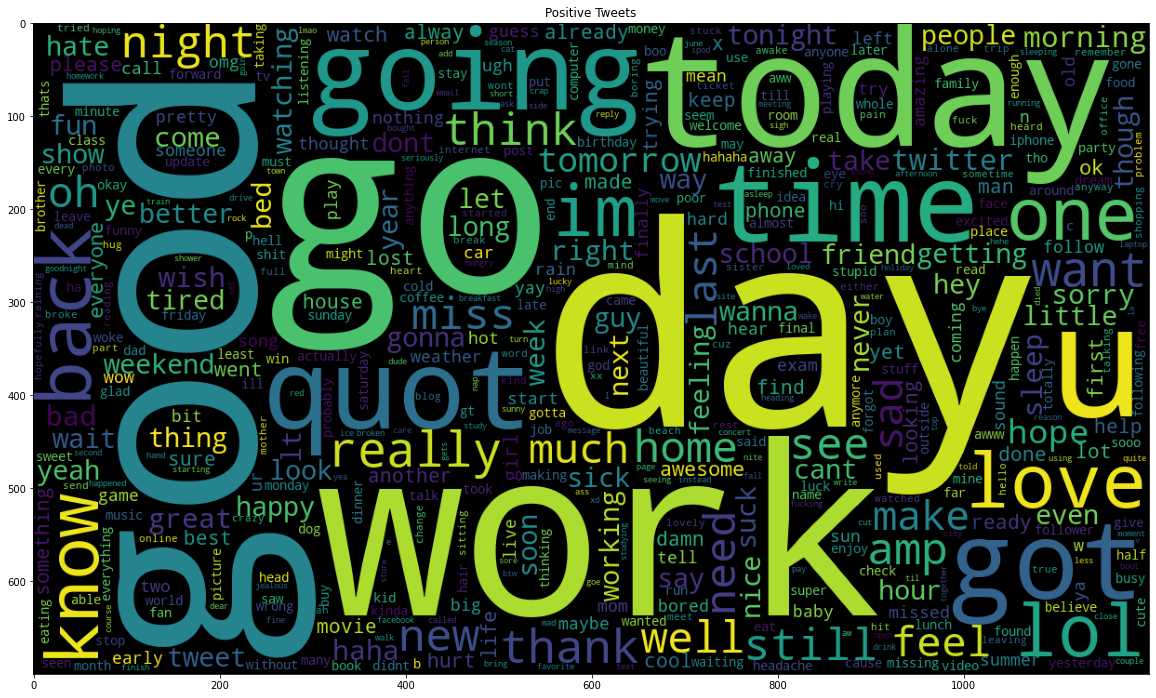

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


data_neg = pandas_df['text_cleaned'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1200 , height = 700,
               collocations=False).generate(" ".join(data_neg))
plt.title('Positive Tweets')
plt.imshow(wc)



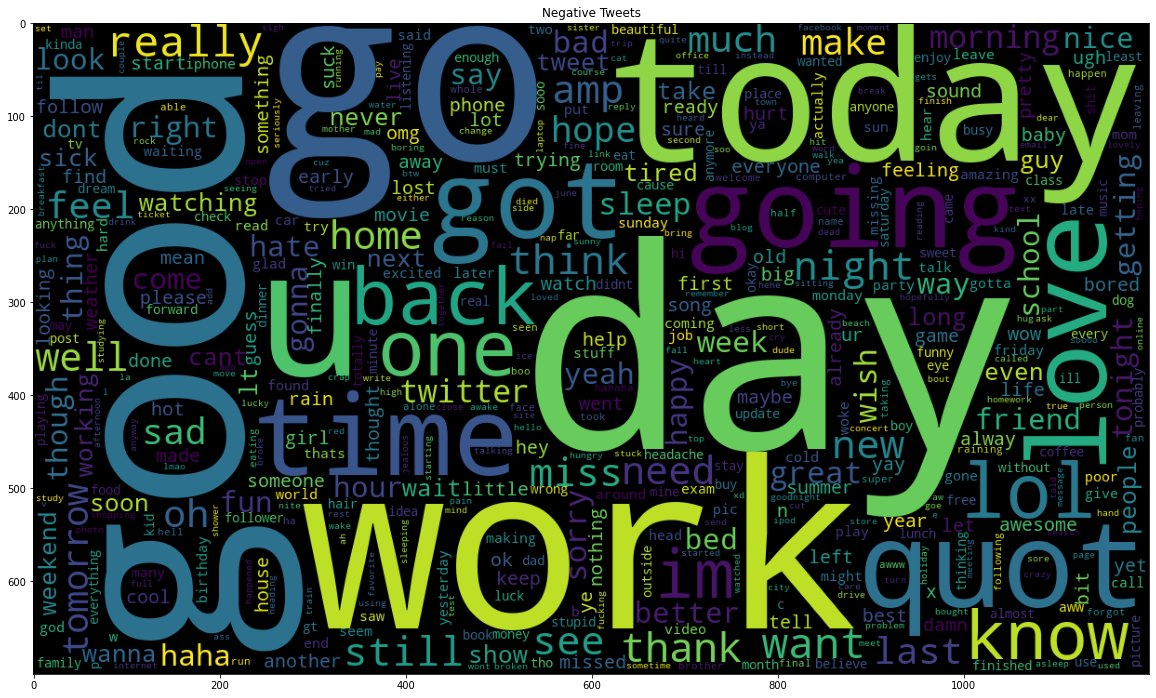

In [26]:
data_pos = pandas_df['text_cleaned'][800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1200 , height = 700,
               collocations=False).generate(" ".join(data_neg))
plt.title('Negative Tweets')
plt.imshow(wc)


#4.3. N-grams

Most common words can be considered 1-gram. Bigram and trigram, two and three-word sequences, are analyzed in this case.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
# N: N-gram, n: Top n N-grams
def get_grams(text_data,N=2, n=20):
       
    #Define CountVectorizer object
    vec = CountVectorizer(ngram_range=(N,N))
    
    #Fit CountVectorizer object in text_data
    bag_of_words = vec.fit_transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [28]:
#20 top results by default
bi_grams = get_grams(pandas_df['text_cleaned'],N=2)
tri_grams = get_grams(pandas_df['text_cleaned'],N=3)

fig = make_subplots(rows=2,cols=1, subplot_titles=("Bi-grams","Tri-grams"))

x,y = zip(*bi_grams)
fig.append_trace(go.Bar(x=x,y=y,name='Bi-gram (two-words sequence)'), row=1,col=1)

x,y = zip(*tri_grams)
fig.append_trace(go.Bar(x=x,y=y,name='Ti-gram (Three-words sequence)'),row=2,col=1)

fig.update_layout(title="Most common N-grams",height=900,width=900,)
fig.update_xaxes(tickangle=45)
fig.show()

#5. Data processing for modelling

##5.1. Tokenization

In [29]:
from pyspark.ml.feature import Tokenizer

#split string in array elements
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens") 
words_tokens = tokenizer.transform(df)
words_tokens.show(10)

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|                work|              [work]|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|
|  0.0|need new glasses ...|[need, new, glass...|
|  0.0|getting changed h...|[getting, changed...|
|  0.0|really time sleep...|[really, time, sl...|
|  0.0|pfff want go back...|[pfff, want, go, ...|
|  0.0|currently watchin...|[currently, watch...|
|  0.0|bad day need comf...|[bad, day, need, ...|
|  0.0|tried install twi...|[tried, install, ...|
|  0.0|casual unprotecte...|[casual, unprotec...|
+-----+--------------------+--------------------+
only showing top 10 rows



##5.2. Count Vectorization

In [30]:
#Apply CountVectorizer
from pyspark.ml.feature import CountVectorizer
count = CountVectorizer (inputCol="words_tokens", outputCol="raw_Features")
model = count.fit(words_tokens)
featurized_Data = model.transform(words_tokens)
featurized_Data.show()

+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|        raw_Features|
+-----+--------------------+--------------------+--------------------+
|  0.0|                work|              [work]|  (262144,[7],[1.0])|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|(262144,[2,26,30,...|
|  0.0|need new glasses ...|[need, new, glass...|(262144,[25,33,10...|
|  0.0|getting changed h...|[getting, changed...|(262144,[4,56,235...|
|  0.0|really time sleep...|[really, time, sl...|(262144,[12,18,35...|
|  0.0|pfff want go back...|[pfff, want, go, ...|(262144,[4,6,13,2...|
|  0.0|currently watchin...|[currently, watch...|(262144,[5,32,61,...|
|  0.0|bad day need comf...|[bad, day, need, ...|(262144,[1,33,48,...|
|  0.0|tried install twi...|[tried, install, ...|(262144,[7,39,121...|
|  0.0|casual unprotecte...|[casual, unprotec...|(262144,[20,81,20...|
|  0.0|good morning worl...|[good, morning, w...|(262144,[0,10,35,...|
|  0.0

##5.3. Feature Extraction with TF-IDF

TF-IDF represents a statistical measure that evaluates the relevance of a word in a document in the collection of documents. This is carried out by multiplying two metrics: the frequency of the word appearing in the paper, and the inverse document frequency of the expression across the set. TF-IDF is commonly employed for scoring words in NLP cases.

In [31]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="raw_Features", outputCol="features")
idfModel = idf.fit(featurized_Data)
rescaledData = idfModel.transform(featurized_Data)

rescaledData.select("label", "features").show()  

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
|  0.0|(262144,[4,6,13,2...|
|  0.0|(262144,[5,32,61,...|
|  0.0|(262144,[1,33,48,...|
|  0.0|(262144,[7,39,121...|
|  0.0|(262144,[20,81,20...|
|  0.0|(262144,[0,10,35,...|
|  0.0|(262144,[24,39,40...|
|  0.0|(262144,[3,147,98...|
|  0.0|(262144,[15,49,29...|
|  0.0|(262144,[21,51,14...|
|  0.0|(262144,[8,31,78,...|
|  0.0|(262144,[66,201,3...|
|  0.0|(262144,[8,31,124...|
|  0.0|(262144,[157,256,...|
|  0.0|(262144,[176,317,...|
+-----+--------------------+
only showing top 20 rows



In [32]:
df_final = rescaledData.select("label", "features")

#6. Data splitting

Split the processed data into train and test datasets.

In [33]:
#Set seed for reproducibility
seed=42
df_train, df_test = df_final.randomSplit([0.85,0.15],seed)

In [34]:
#df_train.show(10)
#df_test.show(10)
#print('Train dataset size: ', df_train.count())
#print('Test dataset size: ', df_test.count())

#7. Model and Metrics

##7.1. Logistic Regression

In [35]:
#Define the model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 15)

#Train the model
model_lr = lr.fit(df_train)

In [36]:
#show predictions
predictions = model_lr.transform(df_test)
pred = predictions.toPandas()
pred.head()


,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2709357631423487, 0.2709357631423487]","[0.4326773809862602, 0.5673226190137398]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2709357631423487, 0.2709357631423487]","[0.4326773809862602, 0.5673226190137398]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2709357631423487, 0.2709357631423487]","[0.4326773809862602, 0.5673226190137398]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2709357631423487, 0.2709357631423487]","[0.4326773809862602, 0.5673226190137398]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2709357631423487, 0.2709357631423487]","[0.4326773809862602, 0.5673226190137398]",1.0


In [37]:
#Model evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')
ROC_area = evaluator.evaluate(predictions)
print(f"ROC Area: {ROC_area}")

ROC Area: 0.8155958309520338


              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76    120195
         1.0       0.75      0.78      0.76    119874

    accuracy                           0.76    240069
   macro avg       0.76      0.76      0.76    240069
weighted avg       0.76      0.76      0.76    240069



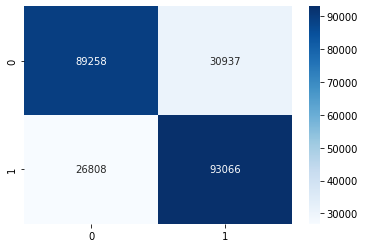

In [38]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = pred['label'].astype('float')
y_pred = pred['prediction']
print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')

In [47]:
def model_Evaluate(model):
    
    predictions = model.transform(df_test)
    pred = predictions.toPandas()
    y_true = pred['label'].astype('float')
    y_pred = pred['prediction']
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_true, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#model_Evaluate(model_lr)

##7.2.  Decision Tree Classifier

In [41]:
# #Low convergence in this case
# from pyspark.ml.classification import DecisionTreeClassifier

# dtc = DecisionTreeClassifier(labelCol = "label", featuresCol = "features")

# #Train the model
# model_dtc = dtc.fit(df_train)

# #Model evaluation
# model_Evaluate(model_dtc)

##7.3. Random Forest Classifier

In [42]:
# Low convergence in this case
# from pyspark.ml.classification import RandomForestClassifier

# rfc = RandomForestClassifier(labelCol = "label", featuresCol = "features")

# #Train the model
# model_rfc = rfc.fit(df_train)

# #Model evaluation
# model_Evaluate(model_rfc)

##7.4. Gradient-boosted tree classifier


In [43]:
# #Low convergence in this case
# from pyspark.ml.classification import GBTClassifier
# gbtc = GBTClassifier(labelCol = "label", featuresCol = "features")

# #Train the model
# model_gbtc = gbtc.fit(df_train)

# #Model evaluation
# model_Evaluate(model_gbtc)

#7.5. Linear Support Vector Machine

In [44]:
# #Low convergence in this case
# from pyspark.ml.classification import LinearSVC

# SVC = LinearSVC(labelCol = "label", featuresCol = "features")

# #Train the model
# model_SVC = SVC.fit(df_train)

# #Model evaluation
# model_Evaluate(model_SVC)

##7.7. Naive Bayes

In [50]:
# from pyspark.ml.classification import NaiveBayes
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# nb = NaiveBayes(labelCol = "label", featuresCol = "features")

# #Train the model
# model_nb = nb.fit(df_train)

# #Model evaluation
# model_Evaluate(model_nb)

In [ ]:
#Model evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')
ROC_area = evaluator.evaluate(predictions)
print(f"ROC Area: {ROC_area}")

It was observed that Logistic Regression shows the best performance, reaching a 76% accuracy in tweet sentiment classification. Other models exhibited low convergence.

#8. Save the model



In [ ]:
import pickle
file = open('Sentiment-LR.pickle','wb')
pickle.dump(model_lr, file)
file.close()